In [3174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pingouin as pg
import scipy.stats

# Exploratory Data Analysis

In [3176]:
nba_shot_data=pd.read_csv(r'C:\Users\mgang\Desktop\NBA_2023_24_shot_data.csv').dropna()
nba_shot_data.shape

(232541, 29)

In [3177]:
print(nba_shot_data.isna().sum())
#no missing vlaues to handle

print(nba_shot_data.dtypes)

GRID_TYPE              0
GAME_ID                0
GAME_EVENT_ID          0
PLAYER_ID              0
PLAYER_NAME            0
TEAM_ID                0
TEAM_NAME              0
PERIOD                 0
MINUTES_REMAINING      0
SECONDS_REMAINING      0
EVENT_TYPE             0
ACTION_TYPE            0
SHOT_TYPE              0
SHOT_ZONE_BASIC        0
SHOT_ZONE_AREA         0
SHOT_ZONE_RANGE        0
SHOT_DISTANCE          0
LOC_X                  0
LOC_Y                  0
SHOT_ATTEMPTED_FLAG    0
SHOT_MADE_FLAG         0
GAME_DATE              0
HTM                    0
VTM                    0
player_name            0
Season Type            0
HOME_TEAM_NAME         0
AWAY_TEAM_NAME         0
LOCATION               0
dtype: int64
GRID_TYPE              object
GAME_ID                 int64
GAME_EVENT_ID           int64
PLAYER_ID               int64
PLAYER_NAME            object
TEAM_ID                 int64
TEAM_NAME              object
PERIOD                  int64
MINUTES_REMAINING     

In [3178]:
#drop duplicate columns since those columns will never be needed
drop_cols=['player_name', 'HTM', 'VTM']
#can be combined into one column reflecting the time left in the period
nba_shot_data[['MINUTES_REMAINING', 'SECONDS_REMAINING']].head()
nba_shot_data['TIME_REMAINING(S)']=nba_shot_data['MINUTES_REMAINING']*60+nba_shot_data['SECONDS_REMAINING']
print(nba_shot_data[['MINUTES_REMAINING', 'SECONDS_REMAINING', 'TIME_REMAINING(S)']].head())
drop_cols.extend(['MINUTES_REMAINING','SECONDS_REMAINING'])
nba_shot_data['GRID_TYPE'].value_counts()
#only one value for this column, anyways not useful for any kind of analysis so drop
drop_cols.append('GRID_TYPE')
#drop id columns because they have other columns that identify same thing except game_id column, not useful for any inference, ml, eda
drop_cols.extend([ 'GAME_EVENT_ID', 'PLAYER_ID', 'TEAM_ID'])
nba_shot_data.dtypes
#since every row in the dataset represents a shot, this value is always 1, redundant can be dropped
nba_shot_data['SHOT_ATTEMPTED_FLAG'].value_counts()
drop_cols.append('SHOT_ATTEMPTED_FLAG')
drop_cols

   MINUTES_REMAINING  SECONDS_REMAINING  TIME_REMAINING(S)
0                  1                 49                109
1                  0                 11                 11
2                  8                 49                529
3                  9                 30                570
4                  0                 32                 32


['player_name',
 'HTM',
 'VTM',
 'MINUTES_REMAINING',
 'SECONDS_REMAINING',
 'GRID_TYPE',
 'GAME_EVENT_ID',
 'PLAYER_ID',
 'TEAM_ID',
 'SHOT_ATTEMPTED_FLAG']

In [3179]:
#same data as the shot_made_flag, but in text form instead of 1 and 0, can be dropped
print(nba_shot_data['EVENT_TYPE'].value_counts())
drop_cols.append('EVENT_TYPE')
#viewing the unique values and counts in each of the below columns, see if any are redundant
for col in ['ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']:
    print(nba_shot_data[col].value_counts())



EVENT_TYPE
Missed Shot    122403
Made Shot      110138
Name: count, dtype: int64
ACTION_TYPE
Jump Shot                             66981
Pullup Jump shot                      27646
Driving Layup Shot                    20840
Step Back Jump shot                   12056
Driving Floating Jump Shot            11782
Running Layup Shot                     7627
Driving Finger Roll Layup Shot         6568
Running Jump Shot                      6090
Layup Shot                             5602
Cutting Layup Shot                     5512
Tip Layup Shot                         4931
Fadeaway Jump Shot                     4671
Floating Jump shot                     4296
Putback Layup Shot                     4004
Turnaround Fadeaway shot               3838
Driving Floating Bank Jump Shot        3496
Cutting Dunk Shot                      3229
Running Pull-Up Jump Shot              3127
Turnaround Jump Shot                   3123
Running Dunk Shot                      2894
Turnaround Hook Shot       

In [3180]:
#there are alot of different values in the ACTION_TYPE column, possibly too many, might have to classify into a few shot type groups
#ex. layup, dunk, jumpshot, etc.
nba_shot_data['ACTION_TYPE_BASIC']= nba_shot_data['ACTION_TYPE'].apply(
    lambda x: 'Layup' if 'Layup' in x else
              'Dunk' if 'Dunk' in x else
              'Jump Shot' if 'Jump' in x else
              'Hook' if 'Hook' in x else
              'Other'
)


#map shot_type with strings for 2pt and 3pt, make an int
nba_shot_data['SHOT_VAL']=nba_shot_data['SHOT_TYPE'].map({'2PT Field Goal': 2, '3PT Field Goal': 3})
drop_cols.append('SHOT_TYPE')

In [3181]:
nba_shot_data=nba_shot_data.drop(columns=drop_cols)
nba_shot_data.head()

,GAME_ID,PLAYER_NAME,TEAM_NAME,PERIOD,ACTION_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,Season Type,HOME_TEAM_NAME,AWAY_TEAM_NAME,LOCATION,TIME_REMAINING(S),ACTION_TYPE_BASIC,SHOT_VAL
0,22300031,Precious Achiuwa,Toronto Raptors,1,Layup Shot,Restricted Area,Center(C),Less Than 8 ft.,1,-6,16,1,20231117,Regular Season,BOS,TOR,AWAY,109,Layup,2
1,22300031,Precious Achiuwa,Toronto Raptors,1,Jump Shot,Right Corner 3,Right Side(R),24+ ft.,23,232,4,0,20231117,Regular Season,BOS,TOR,AWAY,11,Jump Shot,3
2,22300031,Precious Achiuwa,Toronto Raptors,2,Jump Shot,Left Corner 3,Left Side(L),24+ ft.,22,-229,1,0,20231117,Regular Season,BOS,TOR,AWAY,529,Jump Shot,3
3,22300031,Precious Achiuwa,Toronto Raptors,4,Driving Layup Shot,Restricted Area,Center(C),Less Than 8 ft.,0,-7,-2,1,20231117,Regular Season,BOS,TOR,AWAY,570,Layup,2
4,22300038,Precious Achiuwa,Toronto Raptors,1,Jump Shot,Above the Break 3,Left Side Center(LC),24+ ft.,26,-200,177,0,20231121,Regular Season,TOR,ORL,AWAY,32,Jump Shot,3


# Machine Learning

### Player Clustering

**Clustering players into groups based on a combination of their playstyle,such as preferred shot locations (e.g., restricted area, corner three, mid-range) and shot types (e.g., jump shots, layups), as well as their per game statistics like points, assists, rebounds, and free throw attempts.**

**When given a player name, return players with similar playstyle(shot location/type) and stats**

In [3184]:
#see if the categorical columns out of those listed below can be one hot encoded
#the shot areas and tendencies of different players can be useful if clustering
nba_shot_data[[ 'SHOT_ZONE_BASIC', 'ACTION_TYPE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE']]

,SHOT_ZONE_BASIC,ACTION_TYPE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE
0,Restricted Area,Layup,Center(C),Less Than 8 ft.,1
1,Right Corner 3,Jump Shot,Right Side(R),24+ ft.,23
2,Left Corner 3,Jump Shot,Left Side(L),24+ ft.,22
3,Restricted Area,Layup,Center(C),Less Than 8 ft.,0
4,Above the Break 3,Jump Shot,Left Side Center(LC),24+ ft.,26
...,...,...,...,...,...
232536,Restricted Area,Layup,Center(C),Less Than 8 ft.,0
232537,In The Paint (Non-RA),Jump Shot,Center(C),Less Than 8 ft.,6
232538,In The Paint (Non-RA),Hook,Center(C),Less Than 8 ft.,7
232539,Mid-Range,Jump Shot,Left Side(L),16-24 ft.,17


In [3185]:
#percentage of shots taken from each of the areas in these two columns, probably some overlap so will check it out

print(nba_shot_data['SHOT_ZONE_AREA'].value_counts(normalize=True))
print(nba_shot_data['SHOT_ZONE_BASIC'].value_counts(normalize=True))
#wont drop either column since they represent slightly different things, will handle by one hot encoding

SHOT_ZONE_AREA
Center(C)                0.567044
Left Side Center(LC)     0.128012
Right Side Center(RC)    0.121639
Left Side(L)             0.091515
Right Side(R)            0.089589
Back Court(BC)           0.002202
Name: proportion, dtype: float64
SHOT_ZONE_BASIC
Restricted Area          0.295049
Above the Break 3        0.291454
In The Paint (Non-RA)    0.196864
Mid-Range                0.113189
Left Corner 3            0.052644
Right Corner 3           0.048744
Backcourt                0.002056
Name: proportion, dtype: float64


In [3186]:
from scipy.stats import chi2_contingency

#checking association between action_type_basic and shot_zone_range
#likely to have some overlap, ex. layups and dunks are going to always be from the 'Less than 8 ft. zone'
#Chi-square test of independence to see likelihood of a relationship b/w these two columns being non-random
contingency=pd.crosstab(nba_shot_data['ACTION_TYPE_BASIC'], nba_shot_data['SHOT_ZONE_RANGE'])
chi2, p, dof, expected=chi2_contingency(contingency)
print(f"Chi-square statistic: {chi2:.3f}")
print(f"p-value: {p:.4f}")
n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
print(f"Cramér’s V: {cramers_v:.3f}")

Chi-square statistic: 187402.285
p-value: 0.0000
Cramér’s V: 0.449


**Chi-square statistic and p value suggest strong likelihood that the categories are linked.**

**Cramer's V of 0.449 indicates a strong correlation between the two columns.**

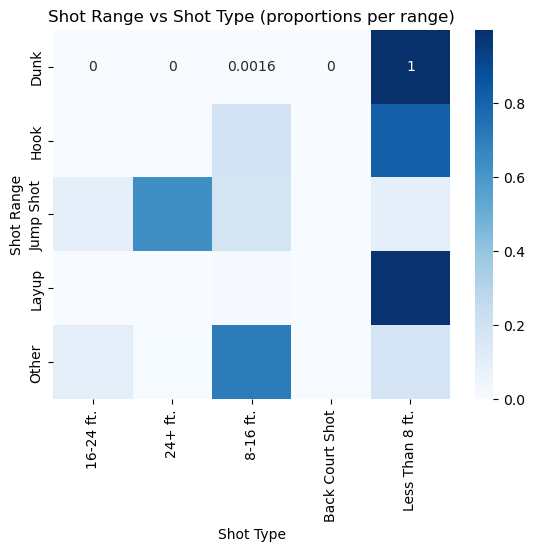

In [3188]:
#visualize
#showing contingency normalized to show proportion of each shot type in each range
sns.heatmap((contingency.div(contingency.sum(axis=1), axis=0)), cmap='Blues', annot=True)
plt.title("Shot Range vs Shot Type (proportions per range)")
plt.xlabel("Shot Type")
plt.ylabel("Shot Range")
plt.show()


In [3189]:
print(nba_shot_data['ACTION_TYPE_BASIC'].value_counts(normalize=True))

ACTION_TYPE_BASIC
Jump Shot    0.618897
Layup        0.272778
Dunk         0.059499
Hook         0.029668
Other        0.019158
Name: proportion, dtype: float64


In [3190]:
#encoding the above columns
nba_shot_data_encoded = pd.get_dummies(nba_shot_data[["SHOT_ZONE_BASIC", "ACTION_TYPE_BASIC", "SHOT_ZONE_AREA", "SHOT_ZONE_RANGE"]]).astype(int)
nba_shot_data_encoded.head()

,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_Backcourt,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,SHOT_ZONE_AREA_Center(C),SHOT_ZONE_AREA_Left Side Center(LC),SHOT_ZONE_AREA_Left Side(L),SHOT_ZONE_AREA_Right Side Center(RC),SHOT_ZONE_AREA_Right Side(R),SHOT_ZONE_RANGE_16-24 ft.,SHOT_ZONE_RANGE_24+ ft.,SHOT_ZONE_RANGE_8-16 ft.,SHOT_ZONE_RANGE_Back Court Shot,SHOT_ZONE_RANGE_Less Than 8 ft.
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


In [3191]:
#back court shots are usually just hail mary shots at the end of the quarter, not useful for analysis and only adds noise so will drop
nba_shot_data_encoded.drop(columns=['SHOT_ZONE_RANGE_Back Court Shot', 'SHOT_ZONE_BASIC_Backcourt'])

,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,ACTION_TYPE_BASIC_Layup,...,SHOT_ZONE_AREA_Back Court(BC),SHOT_ZONE_AREA_Center(C),SHOT_ZONE_AREA_Left Side Center(LC),SHOT_ZONE_AREA_Left Side(L),SHOT_ZONE_AREA_Right Side Center(RC),SHOT_ZONE_AREA_Right Side(R),SHOT_ZONE_RANGE_16-24 ft.,SHOT_ZONE_RANGE_24+ ft.,SHOT_ZONE_RANGE_8-16 ft.,SHOT_ZONE_RANGE_Less Than 8 ft.
0,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232536,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
232537,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
232538,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
232539,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0


In [3192]:
#adding player name and shot distance columns for each shot
nba_shot_data_encoded["PLAYER_NAME"] = nba_shot_data["PLAYER_NAME"]
nba_shot_data_encoded["SHOT_DISTANCE"] = nba_shot_data["SHOT_DISTANCE"]

cols=['SHOT_ZONE_BASIC_Above the Break 3', 
       'SHOT_ZONE_BASIC_In The Paint (Non-RA)',
       'SHOT_ZONE_BASIC_Left Corner 3', 'SHOT_ZONE_BASIC_Mid-Range',
       'SHOT_ZONE_BASIC_Restricted Area', 'SHOT_ZONE_BASIC_Right Corner 3',
       'ACTION_TYPE_BASIC_Dunk', 'ACTION_TYPE_BASIC_Hook',
       'ACTION_TYPE_BASIC_Jump Shot', 'ACTION_TYPE_BASIC_Layup',
       'ACTION_TYPE_BASIC_Other', 
       'SHOT_ZONE_AREA_Center(C)', 'SHOT_ZONE_AREA_Left Side Center(LC)',
       'SHOT_ZONE_AREA_Left Side(L)', 'SHOT_ZONE_AREA_Right Side Center(RC)',
       'SHOT_ZONE_AREA_Right Side(R)', 'SHOT_ZONE_RANGE_16-24 ft.',
       'SHOT_ZONE_RANGE_24+ ft.', 'SHOT_ZONE_RANGE_8-16 ft.',
        'SHOT_ZONE_RANGE_Less Than 8 ft.',
        'SHOT_DISTANCE']


#new data set grouped by PLAYER_NAME, now each encoded column will the the proportion of shots taken from that area or that action type
player_shot_proportions=(nba_shot_data_encoded.groupby('PLAYER_NAME')[cols]
          .mean()#proportions for each encoded column
          .reset_index()
          .round(3) #round to 3 decimal places to make appearance cleaner
    )

#rename the column to represent the values accurately
player_shot_proportions=player_shot_proportions.rename(columns={'SHOT_DISTANCE':'MEAN_SHOT_DISTANCE'})
player_shot_proportions
    

,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,SHOT_ZONE_AREA_Center(C),SHOT_ZONE_AREA_Left Side Center(LC),SHOT_ZONE_AREA_Left Side(L),SHOT_ZONE_AREA_Right Side Center(RC),SHOT_ZONE_AREA_Right Side(R),SHOT_ZONE_RANGE_16-24 ft.,SHOT_ZONE_RANGE_24+ ft.,SHOT_ZONE_RANGE_8-16 ft.,SHOT_ZONE_RANGE_Less Than 8 ft.,MEAN_SHOT_DISTANCE
0,AJ Green,0.646,0.024,0.118,0.085,0.042,0.085,0.000,0.000,0.948,...,0.236,0.226,0.127,0.307,0.104,0.061,0.849,0.042,0.047,23.354
1,AJ Griffin,0.484,0.194,0.097,0.097,0.081,0.048,0.016,0.000,0.887,...,0.306,0.274,0.113,0.210,0.097,0.065,0.629,0.081,0.226,18.984
2,AJ Lawson,0.154,0.123,0.154,0.023,0.423,0.123,0.108,0.000,0.523,...,0.546,0.077,0.177,0.069,0.131,0.015,0.431,0.015,0.538,11.738
3,Aaron Gordon,0.108,0.108,0.042,0.055,0.639,0.047,0.261,0.018,0.282,...,0.757,0.049,0.067,0.054,0.072,0.022,0.197,0.073,0.707,7.091
4,Aaron Holiday,0.400,0.201,0.043,0.108,0.170,0.074,0.005,0.012,0.767,...,0.480,0.161,0.089,0.151,0.118,0.048,0.518,0.173,0.259,16.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,Zach LaVine,0.367,0.077,0.045,0.168,0.306,0.037,0.040,0.011,0.646,...,0.505,0.194,0.085,0.141,0.074,0.125,0.449,0.066,0.359,15.149
564,Zavier Simpson,0.278,0.296,0.019,0.130,0.259,0.019,0.019,0.204,0.481,...,0.574,0.111,0.056,0.148,0.111,0.093,0.315,0.204,0.389,12.926
565,Zeke Nnaji,0.092,0.099,0.020,0.039,0.711,0.039,0.184,0.000,0.197,...,0.875,0.026,0.033,0.013,0.053,0.007,0.151,0.053,0.789,5.592
566,Ziaire Williams,0.291,0.122,0.095,0.116,0.262,0.108,0.095,0.005,0.712,...,0.415,0.167,0.151,0.124,0.138,0.069,0.495,0.106,0.325,15.426


In [3193]:
merged_player_stats_unscaled.dtypes

PLAYER_NAME                               object
SHOT_ZONE_BASIC_Above the Break 3        float64
SHOT_ZONE_BASIC_In The Paint (Non-RA)    float64
SHOT_ZONE_BASIC_Left Corner 3            float64
SHOT_ZONE_BASIC_Mid-Range                float64
SHOT_ZONE_BASIC_Restricted Area          float64
SHOT_ZONE_BASIC_Right Corner 3           float64
ACTION_TYPE_BASIC_Dunk                   float64
ACTION_TYPE_BASIC_Hook                   float64
ACTION_TYPE_BASIC_Jump Shot              float64
ACTION_TYPE_BASIC_Layup                  float64
ACTION_TYPE_BASIC_Other                  float64
SHOT_ZONE_AREA_Center(C)                 float64
SHOT_ZONE_AREA_Left Side Center(LC)      float64
SHOT_ZONE_AREA_Left Side(L)              float64
SHOT_ZONE_AREA_Right Side Center(RC)     float64
SHOT_ZONE_AREA_Right Side(R)             float64
SHOT_ZONE_RANGE_16-24 ft.                float64
SHOT_ZONE_RANGE_24+ ft.                  float64
SHOT_ZONE_RANGE_8-16 ft.                 float64
SHOT_ZONE_RANGE_Less

In [3194]:
#checking if duplicates exist in player name columns
print(player_shot_proportions['PLAYER_NAME'].duplicated().any())


False


In [3195]:
#get shooting percentages for three point shots(24+ ft), mid-range(8-24 ft.), close_shots(<8 ft.) and only selecting PLAYER_NAME and SHOT_MADE_FLAG columns
threes_data=nba_shot_data[nba_shot_data['SHOT_ZONE_RANGE']=='24+ ft.'][['PLAYER_NAME','SHOT_MADE_FLAG']]
midrange_data = nba_shot_data[(nba_shot_data['SHOT_ZONE_RANGE'] == '8-16 ft.') |(nba_shot_data['SHOT_ZONE_RANGE'] == '16-24 ft.')]
close_data=nba_shot_data[nba_shot_data['SHOT_ZONE_RANGE']=='Less Than 8 ft.'][['PLAYER_NAME','SHOT_MADE_FLAG']]

#dictionary for each zone for naming columns and using different dataframes in for loop
zone_data={
    'CLOSE':close_data,
    'MID': midrange_data,
    'THREES': threes_data
}



zone_stats=[]

for zone, df_zone in zone_data.items():
    stats=df_zone.groupby('PLAYER_NAME').agg(
        **{
            f'FGA_{zone}': ('SHOT_MADE_FLAG', 'count'), #shot attempts at each zone, sum for entire season NOT per game
            f'FGM_{zone}': ('SHOT_MADE_FLAG', 'sum'),  #shot makes at each zone, sum for entire season NOT per game
            f'FG_PCT_{zone}': ('SHOT_MADE_FLAG', 'mean') #fg percentage at each zone
            
        }
    )
    zone_stats.append(stats) #appending to zone stats list

print(zone_stats)

player_shooting=pd.concat(zone_stats, axis=1).reset_index()
player_shooting=player_shooting.fillna(0) #replacing all NaN with 0
player_shooting.head()

#onlyt getting the percentage columns and adding to a df
#selecting all rows and columns that start with FG_PCT or FGA
FG_cols=player_shooting.loc[:, (player_shooting.columns.str.startswith('FG_PCT'))| (player_shooting.columns.str.startswith('FGA')) ].round(3)
FG_cols['PLAYER_NAME']=player_shooting['PLAYER_NAME']

FG_cols

[                 FGA_CLOSE  FGM_CLOSE  FG_PCT_CLOSE
PLAYER_NAME                                        
AJ Green                10          7      0.700000
AJ Griffin              14          5      0.357143
AJ Lawson               70         41      0.585714
Aaron Gordon           590        393      0.666102
Aaron Holiday          108         57      0.527778
...                    ...        ...           ...
Zach LaVine            135         76      0.562963
Zavier Simpson          21          8      0.380952
Zeke Nnaji             120         64      0.533333
Ziaire Williams        123         71      0.577236
Zion Williamson        980        589      0.601020

[560 rows x 3 columns],                  FGA_MID  FGM_MID  FG_PCT_MID
PLAYER_NAME                                  
AJ Green              22       11    0.500000
AJ Griffin             9        3    0.333333
AJ Lawson              4        2    0.500000
Aaron Gordon          79       23    0.291139
Aaron Holiday         

,FGA_CLOSE,FG_PCT_CLOSE,FGA_MID,FG_PCT_MID,FGA_THREES,FG_PCT_THREES,PLAYER_NAME
0,10.0,0.700,22.0,0.500,180.0,0.394,AJ Green
1,14.0,0.357,9.0,0.333,39.0,0.256,AJ Griffin
2,70.0,0.586,4.0,0.500,56.0,0.268,AJ Lawson
3,590.0,0.666,79.0,0.291,164.0,0.311,Aaron Gordon
4,108.0,0.528,92.0,0.489,216.0,0.389,Aaron Holiday
...,...,...,...,...,...,...,...
563,0.0,0.000,1.0,0.000,8.0,0.125,Frank Ntilikina
564,0.0,0.000,2.0,0.500,1.0,0.000,Isaiah Wong
565,0.0,0.000,1.0,0.000,0.0,0.000,Markquis Nowell
566,0.0,0.000,1.0,0.000,7.0,0.286,Mason Jones


In [3196]:
#merge FG_cols with player_shot_proportions
player_shot_proportions=player_shot_proportions.merge(FG_cols, on='PLAYER_NAME',how='inner' )

player_shot_proportions



,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,SHOT_ZONE_RANGE_24+ ft.,SHOT_ZONE_RANGE_8-16 ft.,SHOT_ZONE_RANGE_Less Than 8 ft.,MEAN_SHOT_DISTANCE,FGA_CLOSE,FG_PCT_CLOSE,FGA_MID,FG_PCT_MID,FGA_THREES,FG_PCT_THREES
0,AJ Green,0.646,0.024,0.118,0.085,0.042,0.085,0.000,0.000,0.948,...,0.849,0.042,0.047,23.354,10.0,0.700,22.0,0.500,180.0,0.394
1,AJ Griffin,0.484,0.194,0.097,0.097,0.081,0.048,0.016,0.000,0.887,...,0.629,0.081,0.226,18.984,14.0,0.357,9.0,0.333,39.0,0.256
2,AJ Lawson,0.154,0.123,0.154,0.023,0.423,0.123,0.108,0.000,0.523,...,0.431,0.015,0.538,11.738,70.0,0.586,4.0,0.500,56.0,0.268
3,Aaron Gordon,0.108,0.108,0.042,0.055,0.639,0.047,0.261,0.018,0.282,...,0.197,0.073,0.707,7.091,590.0,0.666,79.0,0.291,164.0,0.311
4,Aaron Holiday,0.400,0.201,0.043,0.108,0.170,0.074,0.005,0.012,0.767,...,0.518,0.173,0.259,16.770,108.0,0.528,92.0,0.489,216.0,0.389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,Zach LaVine,0.367,0.077,0.045,0.168,0.306,0.037,0.040,0.011,0.646,...,0.449,0.066,0.359,15.149,135.0,0.563,72.0,0.486,169.0,0.349
564,Zavier Simpson,0.278,0.296,0.019,0.130,0.259,0.019,0.019,0.204,0.481,...,0.315,0.204,0.389,12.926,21.0,0.381,16.0,0.250,17.0,0.294
565,Zeke Nnaji,0.092,0.099,0.020,0.039,0.711,0.039,0.184,0.000,0.197,...,0.151,0.053,0.789,5.592,120.0,0.533,9.0,0.111,23.0,0.261
566,Ziaire Williams,0.291,0.122,0.095,0.116,0.262,0.108,0.095,0.005,0.712,...,0.495,0.106,0.325,15.426,123.0,0.577,66.0,0.318,187.0,0.310


**Previously tried to cluster players based on just the above stats, but the model lacked the context of each player's output(points, assists, rebounds, etc.). Will merge with another dataset containing these stats.**

In [3198]:
#downloading separate dataframe with per player statistics

nba_2023_24_player_stats=pd.read_csv(r'C:\Users\mgang\Downloads\nba_player_stats_2023_24.csv')
#will try to predict these features in the next part of this project, supervised learning
feature_vars=['Pos', 'Awards', 'MP']
feature_vars_for_predictions=nba_2023_24_player_stats[feature_vars]
print(nba_2023_24_player_stats.dtypes)

Rk                     int64
Player                object
Age                    int64
Team                  object
Pos                   object
G                      int64
GS                     int64
MP                   float64
FG                   float64
FGA                  float64
FG%                  float64
3P                   float64
3PA                  float64
3P%                  float64
2P                   float64
2PA                  float64
2P%                  float64
eFG%                 float64
FT                   float64
FTA                  float64
FT%                  float64
ORB                  float64
DRB                  float64
TRB                  float64
AST                  float64
STL                  float64
BLK                  float64
TOV                  float64
PF                   float64
PTS                  float64
Awards                object
Player-additional     object
dtype: object


In [3199]:
import re
import unicodedata



def normalize_name(name):
    if pd.isna(name):
        return None
    
    # ensure it's a string
    name = str(name).lower().strip()

    # Remove accents (normalize to ASCII)
    name = ''.join(
        c for c in unicodedata.normalize('NFKD', name)
        if not unicodedata.combining(c)
    )
    
    # remove suffixes like Jr., Sr., II, III
    name = re.sub(r'\b(jr|sr|ii|iii)\b', '', name)
    
    # remove periods and extra whitespace
    name = re.sub(r'\.', '', name)
    name = re.sub(r'\s+', ' ', name)
    
    # lower case, some players have capital letters in the middle of their name, causes issues
    name = name.lower()
    return name.strip()

# Apply only to the Player column
nba_2023_24_player_stats['Player'] = nba_2023_24_player_stats['Player'].apply(normalize_name)
player_shot_proportions['PLAYER_NAME'] = player_shot_proportions['PLAYER_NAME'].apply(normalize_name)

#players present in nba_2023_24_player_stats but missing in player_shot_proportions
print("players present in nba_2023_24_player_stats but missing in player_shot_proportions:")

print(set(nba_2023_24_player_stats['Player']) - set(player_shot_proportions['PLAYER_NAME']))
#vice versa
print("players present in player_shot_proportions but missing in nba_2023_24_player_stats:")

print(set(player_shot_proportions['PLAYER_NAME']) - set(nba_2023_24_player_stats['Player']))


players present in nba_2023_24_player_stats but missing in player_shot_proportions:
{'ron harper', 'justin jackson', 'javonte smart', 'malcolm cazalon'}
players present in player_shot_proportions but missing in nba_2023_24_player_stats:
set()


In [3200]:
#drop the players who were in nba_2023_24_player_stats, but not in player_shot_proportions, did not take a shot during the season
names_to_drop=['ron harper', 'justin jackson', 'javonte smart', 'malcolm cazalon']
nba_2023_24_player_stats= nba_2023_24_player_stats[~nba_2023_24_player_stats['Player'].isin(names_to_drop)]
nba_2023_24_player_stats['PLAYER_NAME']=nba_2023_24_player_stats['Player']

#drop some columns that are already accounted for by player_shot_proportions or will not be useful
drop_cols_b=['Rk', 'Player','Age', 'Team', 'GS', '3P', '3PA','3P%', '2P', '2PA', '2P%', 'FT', 'eFG%', 'TRB','Awards', 'Player-additional', 'MP', 'FG', 'FGA', 'FG%', 'PF' ]
nba_2023_24_player_stats=nba_2023_24_player_stats.drop(columns=drop_cols_b)
nba_2023_24_player_stats.dtypes

Pos             object
G                int64
FTA            float64
FT%            float64
ORB            float64
DRB            float64
AST            float64
STL            float64
BLK            float64
TOV            float64
PTS            float64
PLAYER_NAME     object
dtype: object

In [3201]:
merged_player_stats = player_shot_proportions.merge(
    nba_2023_24_player_stats,  
    on='PLAYER_NAME',
    how='inner'
).reset_index(drop=True)

merged_player_stats_unscaled=merged_player_stats.copy()
merged_player_stats=merged_player_stats.drop(columns=['Pos'])

In [3202]:
#changing the FGA attempts columns to be divided by number of games from each player, so it doesnt take over the clustering model based on magnitude
FGA_cols_old=['FGA_CLOSE', 'FGA_MID', 'FGA_THREES']
merged_player_stats[FGA_cols] = merged_player_stats[FGA_cols].div(merged_player_stats['G'], axis=0)

# Create new column names
FGA_cols_new = [col + '_per_game' for col in FGA_cols_old]

# Assign the new names
merged_player_stats.rename(columns=dict(zip(FGA_cols_old, FGA_cols_new)), inplace=True)


merged_player_stats.dtypes


PLAYER_NAME                               object
SHOT_ZONE_BASIC_Above the Break 3        float64
SHOT_ZONE_BASIC_In The Paint (Non-RA)    float64
SHOT_ZONE_BASIC_Left Corner 3            float64
SHOT_ZONE_BASIC_Mid-Range                float64
SHOT_ZONE_BASIC_Restricted Area          float64
SHOT_ZONE_BASIC_Right Corner 3           float64
ACTION_TYPE_BASIC_Dunk                   float64
ACTION_TYPE_BASIC_Hook                   float64
ACTION_TYPE_BASIC_Jump Shot              float64
ACTION_TYPE_BASIC_Layup                  float64
ACTION_TYPE_BASIC_Other                  float64
SHOT_ZONE_AREA_Center(C)                 float64
SHOT_ZONE_AREA_Left Side Center(LC)      float64
SHOT_ZONE_AREA_Left Side(L)              float64
SHOT_ZONE_AREA_Right Side Center(RC)     float64
SHOT_ZONE_AREA_Right Side(R)             float64
SHOT_ZONE_RANGE_16-24 ft.                float64
SHOT_ZONE_RANGE_24+ ft.                  float64
SHOT_ZONE_RANGE_8-16 ft.                 float64
SHOT_ZONE_RANGE_Less

In [3203]:
#check missing values
merged_player_stats.isna().sum()

#impute FT% with league average
merged_player_stats['FT%']=merged_player_stats['FT%'].fillna(merged_player_stats['FT%'].mean())
merged_player_stats.isna().sum()


PLAYER_NAME                              0
SHOT_ZONE_BASIC_Above the Break 3        0
SHOT_ZONE_BASIC_In The Paint (Non-RA)    0
SHOT_ZONE_BASIC_Left Corner 3            0
SHOT_ZONE_BASIC_Mid-Range                0
SHOT_ZONE_BASIC_Restricted Area          0
SHOT_ZONE_BASIC_Right Corner 3           0
ACTION_TYPE_BASIC_Dunk                   0
ACTION_TYPE_BASIC_Hook                   0
ACTION_TYPE_BASIC_Jump Shot              0
ACTION_TYPE_BASIC_Layup                  0
ACTION_TYPE_BASIC_Other                  0
SHOT_ZONE_AREA_Center(C)                 0
SHOT_ZONE_AREA_Left Side Center(LC)      0
SHOT_ZONE_AREA_Left Side(L)              0
SHOT_ZONE_AREA_Right Side Center(RC)     0
SHOT_ZONE_AREA_Right Side(R)             0
SHOT_ZONE_RANGE_16-24 ft.                0
SHOT_ZONE_RANGE_24+ ft.                  0
SHOT_ZONE_RANGE_8-16 ft.                 0
SHOT_ZONE_RANGE_Less Than 8 ft.          0
MEAN_SHOT_DISTANCE                       0
FGA_CLOSE_per_game                       0
FG_PCT_CLOS

In [3204]:
merged_player_stats_unscaled=merged_player_stats.copy()
merged_player_stats.dtypes
#dropping games column, not useful for clustering based on playstyle, only needed it to get per game Field goal attempts
merged_player_stats=merged_player_stats.drop(columns=['G'])


In [3205]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#I tried the model initially using standard scaler, but using this players tend to be clustered just based on stats(pts, rebounds, assists, etc.) vs 
#playstyle (shot locations and action types ex. percent of jumpshots, layups, etc.)
scaler=MinMaxScaler()

stats_to_scale=['MEAN_SHOT_DISTANCE','FTA' ,'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS','FGA_CLOSE_per_game', 'FGA_MID_per_game', 'FGA_THREES_per_game','FG_PCT_CLOSE', 'FG_PCT_MID', 'FG_PCT_THREES']

#getting all the shot_zone and action type columns so I can multiply by 100 and make into a percentage for the unscaled df, easier to interpret than the decimals
shot_loc_and_action_type_cols=[col for col in merged_player_stats_unscaled if col not in stats_to_scale]
shot_loc_and_action_type_cols.remove('PLAYER_NAME', )
merged_player_stats_unscaled[shot_loc_and_action_type_cols]=(merged_player_stats_unscaled[shot_loc_and_action_type_cols]).round(3)

stats_scale_factor=0.4
#min max scaling for all the features above, using min max will emphasise the encoded shot location columns rather than just raw stats to account for playstyle
#in the clustering algorithm this will cluster based on efficiency as well as the percentage of shots taken from all shot locations from the original data set
merged_player_stats[stats_to_scale]=scaler.fit_transform(merged_player_stats[stats_to_scale])

merged_player_stats[stats_to_scale] = merged_player_stats[stats_to_scale] / merged_player_stats[stats_to_scale].max() * stats_scale_factor







In [3206]:
merged_player_stats[stats_to_scale]

,MEAN_SHOT_DISTANCE,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,FGA_CLOSE_per_game,FGA_MID_per_game,FGA_THREES_per_game,FG_PCT_CLOSE,FG_PCT_MID,FG_PCT_THREES
0,0.361615,0.010345,0.3580,0.017391,0.039604,0.018349,0.038095,0.011111,0.018182,0.051873,0.005102,0.013680,0.094837,0.2800,0.2000,0.1576
1,0.293950,0.003448,0.4000,0.008696,0.031683,0.011009,0.019048,0.011111,0.036364,0.027666,0.020000,0.015670,0.057534,0.1428,0.1332,0.1024
2,0.181752,0.017241,0.2608,0.026087,0.035644,0.018349,0.038095,0.011111,0.027273,0.036888,0.047619,0.003316,0.039340,0.2344,0.2000,0.1072
3,0.109798,0.127586,0.2632,0.208696,0.162376,0.128440,0.152381,0.066667,0.127273,0.160231,0.230920,0.037683,0.066285,0.2664,0.1164,0.1244
4,0.259668,0.027586,0.3684,0.026087,0.051485,0.066055,0.095238,0.011111,0.063636,0.076081,0.039560,0.041071,0.081705,0.2112,0.1956,0.1556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,0.234568,0.141379,0.3416,0.026087,0.190099,0.143119,0.152381,0.033333,0.190909,0.224784,0.154286,0.100286,0.199452,0.2252,0.1944,0.1396
564,0.200147,0.020690,0.3000,0.052174,0.091089,0.132110,0.190476,0.044444,0.127273,0.069164,0.085714,0.079592,0.071654,0.1524,0.1000,0.1176
565,0.086587,0.037931,0.2708,0.095652,0.043564,0.022018,0.057143,0.077778,0.045455,0.036888,0.059113,0.005403,0.011700,0.2132,0.0444,0.1044
566,0.238857,0.051724,0.3308,0.060870,0.110891,0.055046,0.133333,0.022222,0.118182,0.094524,0.068908,0.045063,0.108184,0.2308,0.1272,0.1240


C:\Users\mgang\anaconda3a\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\mgang\anaconda3a\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\mgang\anaconda3a\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\mgang\anaconda3a\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Wi

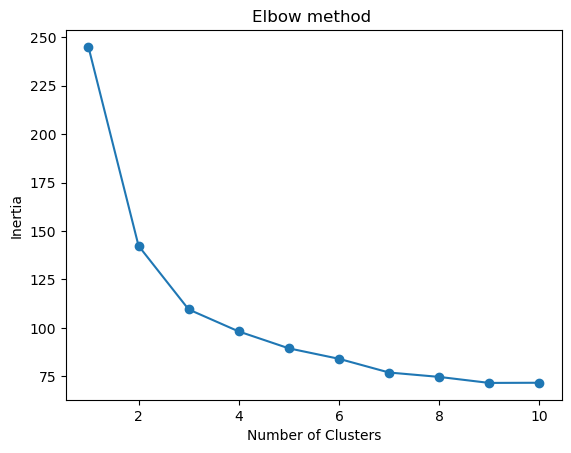

In [3207]:
from sklearn.cluster import KMeans

#testing to see what the optimal amount of clusters is
X=merged_player_stats.drop(columns=['PLAYER_NAME'])
seed=1
n_clusters=range(1, 11)
inertia=[]
for n in n_clusters:
    kmeans=KMeans(n_clusters=n, random_state=seed)#initialize model
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(n_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow method ')
plt.show()

In [3208]:


kmeans=KMeans(n_clusters=4, random_state=seed)
kmeans.fit(X)

#mapping each player's assigned cluster back to both the scaled and unscaled dataframes
merged_player_stats['CLUSTER']=kmeans.labels_
merged_player_stats_unscaled['CLUSTER']=kmeans.labels_
#viewing each player's assigned cluster|
merged_player_stats[['PLAYER_NAME', 'CLUSTER']]



C:\Users\mgang\anaconda3a\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,PLAYER_NAME,CLUSTER
0,aj green,0
1,aj griffin,0
2,aj lawson,3
3,aaron gordon,1
4,aaron holiday,0
...,...,...
563,zach lavine,2
564,zavier simpson,2
565,zeke nnaji,1
566,ziaire williams,2


In [3209]:
from sklearn.metrics.pairwise import cosine_similarity

#add cosine similarity explanation


similarity = cosine_similarity(X)
name= 'grayson allen'

# Get top similar players

player_index = np.where(merged_player_stats['PLAYER_NAME'] == name)[0][0]
similar_players = (
    merged_player_stats
    .assign(similarity=similarity[player_index])
    .sort_values("similarity", ascending=False)
    .head(5)
)

#returning the unscaled dataset to see the actual statistics and compare if they are similar
merged_player_stats_unscaled[merged_player_stats_unscaled['PLAYER_NAME'].isin(similar_players['PLAYER_NAME'])]


,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,CLUSTER
63,buddy hield,0.542,0.070,0.076,0.060,0.200,0.052,0.008,0.001,0.764,...,0.7,0.881,0.7,2.5,2.8,0.8,0.5,1.2,12.1,0
159,duncan robinson,0.533,0.123,0.084,0.022,0.152,0.084,0.004,0.003,0.818,...,1.3,0.889,0.2,2.3,2.8,0.7,0.2,1.4,12.9,0
189,grayson allen,0.457,0.114,0.125,0.015,0.217,0.073,0.031,0.006,0.747,...,2.0,0.878,0.6,3.3,3.0,0.9,0.6,1.3,13.5,0
369,luguentz dort,0.436,0.083,0.091,0.061,0.241,0.088,0.040,0.000,0.739,...,2.0,0.826,0.9,2.7,1.4,0.9,0.6,0.9,10.9,0
399,max strus,0.508,0.059,0.093,0.022,0.256,0.059,0.034,0.004,0.716,...,1.4,0.794,0.9,3.9,4.0,0.9,0.4,1.6,12.2,0


In [3210]:
cluster_0=merged_player_stats_unscaled[merged_player_stats_unscaled['CLUSTER']==0]

cluster_1=merged_player_stats_unscaled[merged_player_stats_unscaled['CLUSTER']==1]

cluster_2=merged_player_stats_unscaled[merged_player_stats_unscaled['CLUSTER']==2]

cluster_3=merged_player_stats_unscaled[merged_player_stats_unscaled['CLUSTER']==3]

#will view each cluster in order of points so that higher scoring players are at the top, easier to interpret their playstyles since these players
#get the most game time and shot attempts




In [3211]:
cluster_0.sort_values(by='PTS', ascending=False).head(20) #guards who use three point shooting as their main method to score, 
#lower down the list we find role players who focus on 3 point shooting and defending the oppsoing team's guards

,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,CLUSTER
505,stephen curry,0.551,0.150,0.029,0.127,0.117,0.025,0.000,0.007,0.780,...,4.4,0.923,0.5,4.0,5.1,0.7,0.4,2.8,26.4,0
64,cj mccollum,0.451,0.209,0.028,0.127,0.145,0.040,0.005,0.002,0.830,...,2.1,0.827,0.6,3.7,4.6,0.9,0.6,1.7,20.0,0
346,klay thompson,0.527,0.105,0.041,0.203,0.082,0.041,0.002,0.003,0.851,...,1.8,0.927,0.5,2.8,2.3,0.6,0.5,1.5,17.9,0
174,fred vanvleet,0.514,0.125,0.028,0.174,0.126,0.027,0.000,0.004,0.825,...,3.1,0.860,0.5,3.4,8.1,1.4,0.8,1.7,17.4,0
45,bogdan bogdanovic,0.448,0.161,0.065,0.095,0.161,0.065,0.008,0.005,0.805,...,2.1,0.921,0.7,2.8,3.1,1.2,0.3,1.4,16.9,0
403,michael porter,0.407,0.095,0.078,0.184,0.202,0.033,0.057,0.004,0.767,...,1.4,0.836,1.3,5.7,1.5,0.5,0.7,1.1,16.7,0
250,james harden,0.541,0.180,0.020,0.063,0.170,0.026,0.003,0.003,0.812,...,4.8,0.878,0.5,4.7,8.5,1.1,0.8,2.6,16.6,0
152,donte divincenzo,0.502,0.090,0.100,0.028,0.204,0.073,0.026,0.002,0.777,...,1.4,0.754,0.8,2.9,2.7,1.3,0.4,1.4,15.5,0
141,derrick white,0.477,0.177,0.053,0.062,0.154,0.078,0.018,0.004,0.804,...,2.1,0.901,0.7,3.5,5.2,1.0,1.2,1.5,15.2,0
538,trey murphy,0.559,0.100,0.075,0.031,0.158,0.073,0.069,0.006,0.801,...,2.6,0.815,0.7,4.2,2.2,0.9,0.5,0.6,14.8,0


In [3212]:
cluster_1.sort_values(by='PTS', ascending=False).head(20) #Power forwards and centers who mostly score close to the basket, strong interior defenders 

,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,CLUSTER
184,giannis antetokounmpo,0.088,0.159,0.002,0.127,0.623,0.000,0.193,0.059,0.221,...,10.7,0.657,2.7,8.8,6.5,1.2,1.1,3.4,30.4,1
567,zion williamson,0.015,0.309,0.001,0.016,0.659,0.001,0.080,0.037,0.173,...,7.1,0.702,1.7,4.1,5.0,1.1,0.7,2.8,22.9,1
149,domantas sabonis,0.077,0.280,0.002,0.067,0.571,0.003,0.113,0.135,0.196,...,5.1,0.704,3.6,10.1,8.2,0.9,0.6,3.3,19.4,1
258,jarrett allen,0.005,0.298,0.001,0.067,0.629,0.001,0.245,0.207,0.171,...,4.1,0.742,3.2,7.4,2.7,0.7,1.1,1.6,16.5,1
170,evan mobley,0.066,0.308,0.019,0.054,0.528,0.026,0.237,0.134,0.282,...,3.4,0.719,2.2,7.1,3.2,0.9,1.4,1.8,15.7,1
479,rudy gobert,0.003,0.143,0.000,0.019,0.833,0.000,0.428,0.043,0.077,...,5.1,0.638,3.8,9.2,1.3,0.7,2.1,1.6,14.0,1
3,aaron gordon,0.108,0.108,0.042,0.055,0.639,0.047,0.261,0.018,0.282,...,3.7,0.658,2.4,4.1,3.5,0.8,0.6,1.4,13.9,1
235,jalen duren,0.007,0.271,0.000,0.039,0.683,0.000,0.296,0.110,0.151,...,3.0,0.790,3.1,8.5,2.4,0.5,0.8,2.1,13.8,1
387,mark williams,0.000,0.172,0.000,0.007,0.821,0.000,0.331,0.040,0.106,...,3.4,0.719,4.0,5.7,1.2,0.8,1.1,0.9,12.7,1
426,nic claxton,0.002,0.284,0.003,0.027,0.680,0.003,0.328,0.222,0.107,...,2.8,0.551,2.7,7.2,2.1,0.6,2.1,1.3,11.8,1


In [3213]:
cluster_2.sort_values(by='PTS', ascending=False).head(20) #ball dominant scorers who can score on all three levels (close, midrange, threes), mix of all positions
#all these clusters are sorted by pts, the players at the bottom of this table do not fall into other categories

,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,CLUSTER
282,joel embiid,0.168,0.236,0.006,0.303,0.280,0.003,0.024,0.034,0.618,...,11.6,0.883,2.4,8.6,5.6,1.2,1.7,3.8,34.7,2
370,luka doncic,0.425,0.226,0.008,0.181,0.150,0.007,0.001,0.008,0.753,...,8.7,0.786,0.8,8.4,9.8,1.4,0.5,4.0,33.9,2
497,shai gilgeous-alexander,0.165,0.290,0.011,0.236,0.295,0.003,0.025,0.002,0.604,...,8.7,0.874,0.9,4.7,6.2,2.0,0.9,2.2,30.1,2
233,jalen brunson,0.266,0.319,0.012,0.197,0.177,0.029,0.002,0.006,0.787,...,6.5,0.847,0.6,3.1,6.7,0.9,0.2,2.4,28.7,2
143,devin booker,0.293,0.216,0.021,0.285,0.179,0.006,0.015,0.006,0.760,...,6.7,0.886,0.8,3.7,6.9,0.9,0.4,2.6,27.1,2
335,kevin durant,0.231,0.224,0.023,0.343,0.154,0.025,0.055,0.001,0.768,...,5.6,0.856,0.5,6.1,5.0,0.9,1.2,3.3,27.1,2
267,jayson tatum,0.386,0.132,0.017,0.169,0.283,0.012,0.064,0.002,0.609,...,6.7,0.833,0.9,7.2,4.9,1.0,0.6,2.5,26.9,2
124,de'aaron fox,0.320,0.314,0.034,0.143,0.169,0.020,0.017,0.005,0.738,...,5.7,0.738,0.9,3.7,5.6,2.0,0.4,2.6,26.6,2
151,donovan mitchell,0.415,0.157,0.011,0.156,0.249,0.011,0.018,0.005,0.710,...,5.8,0.865,0.8,4.3,6.1,1.8,0.5,2.8,26.6,2
546,tyrese maxey,0.366,0.209,0.018,0.102,0.288,0.015,0.005,0.003,0.660,...,5.4,0.868,0.5,3.2,6.2,1.0,0.5,1.7,25.9,2


In [3214]:
cluster_3.sort_values(by='PTS', ascending=False).head(20) 

,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,CLUSTER
431,nikola jokic,0.160,0.377,0.004,0.111,0.340,0.002,0.017,0.169,0.464,...,5.5,0.817,2.8,9.5,9.0,1.4,0.9,3.0,26.4,3
362,lebron james,0.251,0.148,0.016,0.129,0.439,0.017,0.070,0.020,0.443,...,5.7,0.750,0.9,6.4,8.3,1.3,0.5,3.5,25.7,3
28,anthony davis,0.068,0.299,0.013,0.169,0.450,0.001,0.160,0.084,0.380,...,6.8,0.816,3.1,9.5,3.5,1.2,2.3,2.1,24.7,3
452,pascal siakam,0.129,0.295,0.026,0.154,0.363,0.031,0.034,0.039,0.462,...,5.0,0.732,1.7,5.3,4.3,0.8,0.3,1.8,21.7,3
17,alperen sengun,0.109,0.349,0.001,0.079,0.458,0.001,0.075,0.176,0.333,...,5.6,0.693,2.9,6.4,5.0,1.2,0.7,2.6,21.1,3
278,jimmy butler,0.091,0.284,0.042,0.180,0.353,0.050,0.057,0.018,0.483,...,7.7,0.858,1.8,3.6,5.0,1.3,0.3,1.7,20.8,3
468,rj barrett,0.181,0.252,0.032,0.048,0.416,0.072,0.050,0.022,0.484,...,5.0,0.715,0.9,4.5,3.3,0.5,0.4,2.2,20.2,3
173,franz wagner,0.265,0.239,0.023,0.043,0.411,0.016,0.056,0.058,0.465,...,4.4,0.850,1.0,4.3,3.7,1.1,0.4,1.9,19.7,3
36,bam adebayo,0.040,0.475,0.001,0.183,0.295,0.005,0.142,0.071,0.494,...,5.5,0.755,2.2,8.1,3.9,1.1,0.9,2.3,19.3,3
131,deandre ayton,0.007,0.371,0.001,0.284,0.331,0.004,0.117,0.162,0.478,...,1.4,0.823,3.2,7.9,1.6,1.0,0.8,1.8,16.7,3


In [3215]:
per_game_stats=stats_to_scale.copy()



cluster_means_scaled = merged_player_stats.groupby('CLUSTER')[per_game_stats].mean().round(3)
cluster_means_scaled


,MEAN_SHOT_DISTANCE,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,FGA_CLOSE_per_game,FGA_MID_per_game,FGA_THREES_per_game,FG_PCT_CLOSE,FG_PCT_MID,FG_PCT_THREES
CLUSTER,,,,,,,,,,,,,,,,
0,0.291,0.028,0.308,0.036,0.070,0.059,0.098,0.027,0.060,0.073,0.036,0.029,0.104,0.214,0.146,0.138
1,0.058,0.062,0.259,0.162,0.137,0.051,0.099,0.083,0.084,0.080,0.120,0.017,0.007,0.246,0.130,0.053
2,0.218,0.079,0.312,0.070,0.114,0.102,0.140,0.048,0.124,0.135,0.106,0.079,0.116,0.225,0.155,0.135
3,0.154,0.049,0.289,0.085,0.097,0.060,0.097,0.042,0.076,0.078,0.090,0.033,0.041,0.228,0.148,0.116


In [3216]:
cluster_means= merged_player_stats_unscaled.groupby('CLUSTER')[per_game_stats].mean().round(3)

#get the stats of the top 10 players in each column, easier to interpret playstyle and output since the data will not be messed up by players who dont get much playing time, 
top10_cluster_means = (
    merged_player_stats_unscaled
    .groupby('CLUSTER')
    .apply(lambda x: x.nlargest(10, 'PTS')[per_game_stats].mean())
    .round(3)
)

top10_cluster_means


C:\Users\mgang\AppData\Local\Temp\ipykernel_1312\1962894255.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, 'PTS')[per_game_stats].mean())


,MEAN_SHOT_DISTANCE,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,FGA_CLOSE_per_game,FGA_MID_per_game,FGA_THREES_per_game,FG_PCT_CLOSE,FG_PCT_MID,FG_PCT_THREES
CLUSTER,,,,,,,,,,,,,,,,
0,18.411,2.58,0.864,0.68,3.77,4.33,0.96,0.62,1.63,17.74,3.406,2.577,8.806,0.561,0.455,0.395
1,4.345,4.84,0.688,2.94,7.22,3.61,0.82,1.16,2.02,17.11,9.781,1.388,0.703,0.662,0.348,0.185
2,14.082,7.24,0.840,0.93,5.46,6.19,1.34,0.69,2.93,28.76,7.737,8.159,7.850,0.625,0.460,0.375
3,9.134,5.26,0.781,2.05,6.55,4.76,1.09,0.75,2.29,21.63,9.641,4.263,2.845,0.628,0.428,0.316


## Interpretation of clusters:

#### Cluster 0: Perimeter scorers and playmakers

Highest average shot distance (18.41 ft), with most shots coming from midrange and three-point areas.

Moderate 3PA per game (8.81) and midrange attempts (2.58).

Strong FG% from midrange (45.5%) and 3PT (39.5%), very efficient perimeter shooting.

Low rebounding (0.68 ORB, 3.77 DRB) and moderate free throw attempts (2.58 FTA), rarely attacking the rim.

High assists (4.33), capable of creating offense for teammates.

Players in this cluster are perimeter scorers who space the floor, take long-range shots, and contribute as playmakers rather than rim attackers.

These players are mostly either smaller guards or 3 and D role players

Top examples: Stephen Curry, Damian Lillard, Mikal Bridges

#### Cluster 1: Interior finishers and big men

Very short average shot distance (4.35 ft), with most attempts in the paint.

High close-range attempts (9.78 per game), very few midrange or threes.

Strong FG% near the rim (66.2%), low 3PT% (18.5%), highly efficient interior scorers.

High rebounding (2.94 ORB, 7.22 DRB) and solid blocks (1.16), providing rim protection.

Moderate assists (3.61), minimal perimeter playmaking.

This cluster represents big men and rim-running forwards who score efficiently near the basket, dominate the boards, and protect the rim.

Top examples: Giannis Antetokounmpo, Jarrett Allen, Rudy Gobert

#### Cluster 2: Star all-around scorers

Mid-level average shot distance (14.08 ft), balanced inside-out shooting.

Mix of shot attempts: close (7.74), midrange (8.16), and threes (7.85).

Highest points per game (28.76), with high free throw rate (7.24 FTA) and solid efficiency across zones.

Highest assists (6.19), strong playmaking for teammates.

Players in this cluster are star guards or wings who can score from anywhere on the court and create offense for others.

Top examples: Devin Booker, Jalen Brunson, Tyrese Maxey

#### Cluster 3: High scoring second/third options who can facilitate

Moderate shot distance (9.13 ft), mostly close and midrange attempts with some threes.

Balanced shot distribution: close (9.64), midrange (4.26), threes (2.85).

Solid FG% across zones (62.8% close, 42.8% mid, 31.6% 3PT).

Moderate rebounds (2.05 ORB, 6.55 DRB) and defensive contributions (1.09 STL, 0.75 BLK).

Good assists (4.76), can function as secondary playmakers.

Players in this cluster are versatile scorers who mix inside-out shooting with some playmaking responsibilities, complementing star scorers.

**NOTE: This group has some outliers with some high level all stars and mvp level players who have unique playstyles, ex. Lebron James, Nikola Jokic**

Top examples: Alperen Sengun, Pascal Siakam, 


# Classifying each cluster

Testing classification models with hyperparameter tuning to see which fits best to predict the cluster of the player

In [3219]:
#check cluster column value counts to see if one class is over/under represented
print(merged_player_stats['CLUSTER'].value_counts(normalize=True))
#will stratify in train test split

CLUSTER
2    0.367958
0    0.286972
3    0.218310
1    0.126761
Name: proportion, dtype: float64


In [3220]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score,precision_score, recall_score, f1_score


from sklearn.ensemble import RandomForestClassifier

X=merged_player_stats_unscaled.drop(columns=['CLUSTER', 'PLAYER_NAME'])
y=merged_player_stats_unscaled['CLUSTER']

print(X.shape)
print(y.shape)

#stratifying to keep the class proportions in the training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

#initialize model
model=RandomForestClassifier()

#parameter grid
rf_param_grid={
    'n_estimators':[50, 100, 150],
    'max_depth':[5, 10, 15, 20]
}

rf_grid_search=GridSearchCV(estimator=model, param_grid=rf_param_grid, cv=5, scoring='accuracy')

rf_grid_search.fit(X_train, y_train)


best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_
best_model=rf_grid_search.best_estimator_


print(f'best params:{best_params}|best_score:{best_score:.2f}')

importances=best_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances.round(2)
}).sort_values(by='Importance', ascending=False)
print(feature_importance)


(568, 37)
(568,)
best params:{'max_depth': 15, 'n_estimators': 50}|best_score:0.94
                                  Feature  Importance
20                     MEAN_SHOT_DISTANCE        0.18
19        SHOT_ZONE_RANGE_Less Than 8 ft.        0.15
11               SHOT_ZONE_AREA_Center(C)        0.13
8             ACTION_TYPE_BASIC_Jump Shot        0.10
17                SHOT_ZONE_RANGE_24+ ft.        0.07
4         SHOT_ZONE_BASIC_Restricted Area        0.06
25                    FGA_THREES_per_game        0.04
9                 ACTION_TYPE_BASIC_Layup        0.04
0       SHOT_ZONE_BASIC_Above the Break 3        0.03
12    SHOT_ZONE_AREA_Left Side Center(LC)        0.03
14   SHOT_ZONE_AREA_Right Side Center(RC)        0.03
35                                    TOV        0.01
30                                    ORB        0.01
23                       FGA_MID_per_game        0.01
21                     FGA_CLOSE_per_game        0.01
1   SHOT_ZONE_BASIC_In The Paint (Non-RA)        0.01

In [3221]:
feature_vars_for_predictions['PLAYER_NAME']=merged_player_stats_unscaled['PLAYER_NAME']
#drop the last 4 rows for players not in the stat sheet
feature_vars_for_predictions=feature_vars_for_predictions.iloc[:-4,:]


merged_player_stats_unscaled


,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,CLUSTER
0,aj green,0.646,0.024,0.118,0.085,0.042,0.085,0.000,0.000,0.948,...,0.3,0.895,0.2,1.0,0.5,0.2,0.1,0.2,4.5,0
1,aj griffin,0.484,0.194,0.097,0.097,0.081,0.048,0.016,0.000,0.887,...,0.1,1.000,0.1,0.8,0.3,0.1,0.1,0.4,2.4,0
2,aj lawson,0.154,0.123,0.154,0.023,0.423,0.123,0.108,0.000,0.523,...,0.5,0.652,0.3,0.9,0.5,0.2,0.1,0.3,3.2,3
3,aaron gordon,0.108,0.108,0.042,0.055,0.639,0.047,0.261,0.018,0.282,...,3.7,0.658,2.4,4.1,3.5,0.8,0.6,1.4,13.9,1
4,aaron holiday,0.400,0.201,0.043,0.108,0.170,0.074,0.005,0.012,0.767,...,0.8,0.921,0.3,1.3,1.8,0.5,0.1,0.7,6.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,zach lavine,0.367,0.077,0.045,0.168,0.306,0.037,0.040,0.011,0.646,...,4.1,0.854,0.3,4.8,3.9,0.8,0.3,2.1,19.5,2
564,zavier simpson,0.278,0.296,0.019,0.130,0.259,0.019,0.019,0.204,0.481,...,0.6,0.750,0.6,2.3,3.6,1.0,0.4,1.4,6.0,2
565,zeke nnaji,0.092,0.099,0.020,0.039,0.711,0.039,0.184,0.000,0.197,...,1.1,0.677,1.1,1.1,0.6,0.3,0.7,0.5,3.2,1
566,ziaire williams,0.291,0.122,0.095,0.116,0.262,0.108,0.095,0.005,0.712,...,1.5,0.827,0.7,2.8,1.5,0.7,0.2,1.3,8.2,2


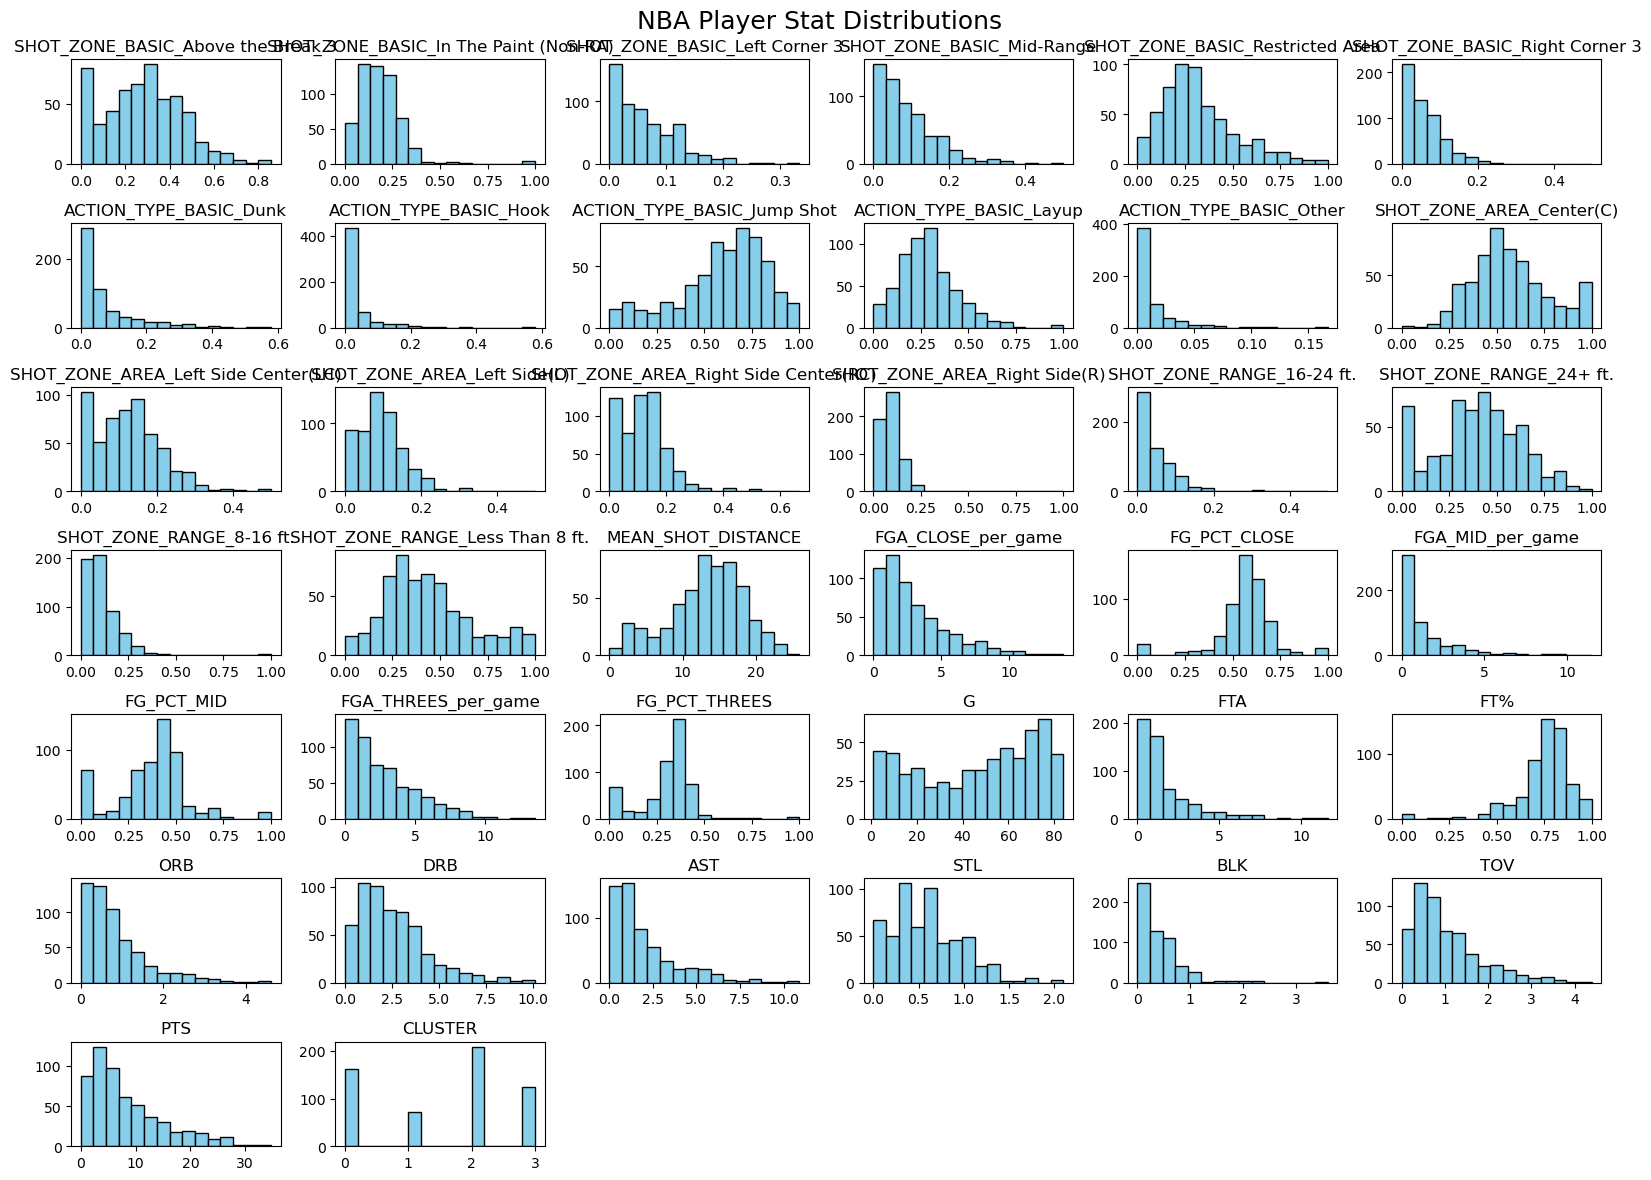

In [3222]:
#plotting histograms of all numeric columns
numeric_player_stats=merged_player_stats_unscaled.select_dtypes(include=['number']).columns

merged_player_stats_unscaled[numeric_player_stats].hist(
    bins=15,
    figsize=(16, 12),
    color='skyblue',
    edgecolor='black',
    grid=False,
    
)
plt.suptitle("NBA Player Stat Distributions", fontsize=18)
plt.tight_layout()

,PLAYER_NAME,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,ACTION_TYPE_BASIC_Dunk,ACTION_TYPE_BASIC_Hook,ACTION_TYPE_BASIC_Jump Shot,...,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS,CLUSTER,Pos
0,aj green,0.646,0.024,0.118,0.085,0.042,0.085,0.000,0.000,0.948,...,0.3580,0.017391,0.039604,0.018349,0.038095,0.011111,0.018182,0.051873,0,C
1,aj griffin,0.484,0.194,0.097,0.097,0.081,0.048,0.016,0.000,0.887,...,0.4000,0.008696,0.031683,0.011009,0.019048,0.011111,0.036364,0.027666,0,PG
2,aj lawson,0.154,0.123,0.154,0.023,0.423,0.123,0.108,0.000,0.523,...,0.2608,0.026087,0.035644,0.018349,0.038095,0.011111,0.027273,0.036888,3,PF
3,aaron gordon,0.108,0.108,0.042,0.055,0.639,0.047,0.261,0.018,0.282,...,0.2632,0.208696,0.162376,0.128440,0.152381,0.066667,0.127273,0.160231,1,PG
4,aaron holiday,0.400,0.201,0.043,0.108,0.170,0.074,0.005,0.012,0.767,...,0.3684,0.026087,0.051485,0.066055,0.095238,0.011111,0.063636,0.076081,0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,zach lavine,0.367,0.077,0.045,0.168,0.306,0.037,0.040,0.011,0.646,...,0.3416,0.026087,0.190099,0.143119,0.152381,0.033333,0.190909,0.224784,2,SG
564,zavier simpson,0.278,0.296,0.019,0.130,0.259,0.019,0.019,0.204,0.481,...,0.3000,0.052174,0.091089,0.132110,0.190476,0.044444,0.127273,0.069164,2,PG
565,zeke nnaji,0.092,0.099,0.020,0.039,0.711,0.039,0.184,0.000,0.197,...,0.2708,0.095652,0.043564,0.022018,0.057143,0.077778,0.045455,0.036888,1,SG
566,ziaire williams,0.291,0.122,0.095,0.116,0.262,0.108,0.095,0.005,0.712,...,0.3308,0.060870,0.110891,0.055046,0.133333,0.022222,0.118182,0.094524,2,SF


ValueError: All arrays must be of the same length

2']